### Emotion dataset

**Imports**

In [28]:
# Text preprocessing pipeline
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import HashingVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from nltk.corpus import stopwords

# Metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics


# imports 
import numpy as np
import pandas as pd
df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Emotions')

In [31]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Alexander
[nltk_data]     Nylund\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [46]:
# Preparing dataset
X = df.loc[:,'discussion_text']
y = df.loc[:,'Label']

# removes all duplicates from list 
Labels = list(dict.fromkeys(y)) 
print(Labels)

# Preprocess pipeline for texts
# and training configuration 
mystopwords = stopwords.words()
top_k_features=1000
# Pipeline inspiration:
# https://towardsdatascience.com/pipeline-for-text-data-pre-processing-a9887b4e2db3

pipe_clf = Pipeline([
    #('vect', CountVectorizer(decode_error='ignore', stop_words='english')),
    #('vect', CountVectorizer(decode_error='strict', stop_words='english')),
    ('vect', CountVectorizer(stop_words=mystopwords, lowercase=True)),
    ('chi2score', SelectKBest(chi2, k=top_k_features)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    #('vect', TfidfVectorizer()),
    #('vect', HashingVectorizer(n_features=2**4)),
    #('tfidf', TfidfTransformer()),
    #('clf', LogisticRegression( penalty='l2', solver='lbfgs', dual=False, multi_class='multinomial', tol=1e-3, max_iter=1000)),
    ('clf', LogisticRegression(multi_class='multinomial', tol=1e-3, fit_intercept=False)),
    #('clf', LogisticRegression( penalty='l2', solver='lbfgs', dual=False, class_weight='balanced', multi_class='multinomial', tol=1e-4)),
])

# possible to get 50-70% accuracy with this dataset 

# Logistic regression parameters:
# - dual: Prefer dual=False when n_samples > n_features
# - tol: Tolerance for stopping criteria.
# - class_weight: dict or ‘balanced’, default=None


['Trust', 'Disgust', 'Anticipation', 'Sadness', 'Anger', 'Fear', 'Joy', 'Surprise']


**Logistic Regression classifier**
- You can use either use scikit-learn or NLTK for building the classifiers.
- test them using part of the labeled dataset as the test set

In [8]:
def get_most_informative_features(clf, vectorizer, 
                                  label_names, 
                                  max_number_informative_features):
    """
    Prints features with the highest coefficient values, per class
    """
    output = []

    
    try:
        feature_names = vectorizer.get_feature_names()

        label_index = len(label_names)
        
        if label_index == 2:
            label_index = 1
            print('features for binary classification!')
        
        for index in range(label_index):
#             print(str(index) + label_names[index])
            #print('clf.coef_:',len(clf.coef_))
            
            # will work nicely only with 2 categories (code {:>30} is just formatting)
#             output.append(f'\n {label_names[index]}: {label_names[index+1]:>30}:')
            output.append('\n' + label_names[index] + ':\n')
            
            #combine feature names with their coefficients
            coefs_with_fns = sorted(zip(clf.coef_[index], feature_names))
            
            #print(coefs_with_fns)
            
            #half for one label, half for the other
            threshold = int(max_number_informative_features / 2)

            top = zip(coefs_with_fns[:threshold],
                      coefs_with_fns[:-(threshold + 1):-1])
            
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                feat = "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
                output.append(feat)
            
            #print('\n'.join(output))
                
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise 
        return '\n'.join(output)

    return '\n'.join(output)

accuracy (simple): 0.24041297935103245


,precision,recall,f1-score,support
Trust,0.0526,0.1111,0.0714,18.0
Disgust,0.2083,0.2198,0.2139,182.0
Anticipation,0.0,0.0,0.0,65.0
Sadness,0.0,0.0,0.0,26.0
Anger,0.0714,0.0167,0.027,60.0
Fear,0.0,0.0,0.0,62.0
Joy,0.0,0.0,0.0,38.0
Surprise,0.3191,0.5286,0.398,227.0
accuracy,0.2404,0.2404,0.2404,0.2404
macro avg,0.0814,0.1095,0.0888,678.0


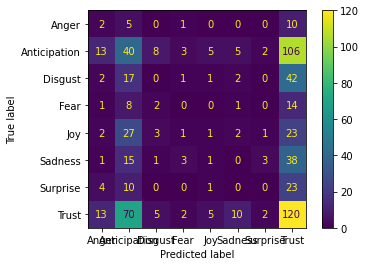

In [59]:
# logistic regression Classifier

# Preparing the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=42) # , stratify=Labels , random_state=99


# Display info about dataset distribution of classes 
from IPython.display import display
import pandas as pd

# print("train")
# arr = pd.DataFrame(np.unique(np.array(y_train), return_counts=True))
# display(arr)

# print("test")
# arr2 = pd.DataFrame(np.unique(np.array(y_test), return_counts=True))
# display(arr2)


# train and predict 
text_clf = pipe_clf.fit(X_train, y_train)
predictions = pipe_clf.predict(X_test)

# score = pipe_clf.score(X_train,y_train)
# print(score)


# print result 
print('accuracy (simple):', accuracy_score(y_test, predictions))
measures_info = metrics.classification_report(y_test, predictions, target_names=Labels, output_dict=True) #, labels=np.unique(predictions) 
info = pd.DataFrame(measures_info).transpose()
info = info.round(decimals=4).astype(object)

display(info)

# Confusion matrix 
# cnf_matrix = metrics.confusion_matrix(y_test, predictions)
# print(cnf_matrix)
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe_clf, X_test, y_test)  
plt.show()

# print(pipe_clf.named_steps['vect'].vocabulary_) # prints vocabulary created by CountVectorizer
#print(pipe_clf.named_steps['vect'].stop_words_)


In [65]:
vectorizer = pipe_clf.named_steps['vect']

clf = pipe_clf.named_steps['clf']


#feature_names = vectorizer.get_feature_names()


imp_features = get_most_informative_features(clf, vectorizer, Labels, 30)


#print('len of coeffients: ', len(clf.coef_[0]), '\n', clf.coef_)

#print('len of intercepts: ', len(clf.intercept_), '\n', clf.intercept_)

print('imp_features\n', imp_features)

imp_features
 
Trust:

	-0.9361	sugars         		1.9025	congrats       
	-0.9067	start          		1.8137	micronase      
	-0.8400	doctor         		1.6956	bmi            
	-0.8385	want           		1.6406	tests          
	-0.8307	a1c            		1.5834	shakes         
	-0.8238	lot            		1.5596	glycemic       
	-0.8013	life           		1.5459	did            
	-0.7950	hello          		1.5160	happens        
	-0.7812	think          		1.4990	parent         
	-0.7803	like           		1.4400	diagonized     
	-0.7450	eating         		1.4307	linked         
	-0.7404	years          		1.3309	50             
	-0.7361	condition      		1.3103	diseases       
	-0.7079	insulin        		1.3079	ketoacidosis   
	-0.7044	months         		1.3034	tell           

Disgust:

	-1.0525	years          		0.6256	hours          
	-0.8243	hi             		0.5995	hello          
	-0.7701	carbs          		0.5696	manage         
	-0.7283	different      		0.5437	issue          
	-0.6347	obesity        		0.5383	do

**TODO**
- Bag-of-words
- Bag-of-n-grams 
- Tf-Idf (is probably shit for our use case)

https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640